# Compensation de mouvement et Compression Video - TP2

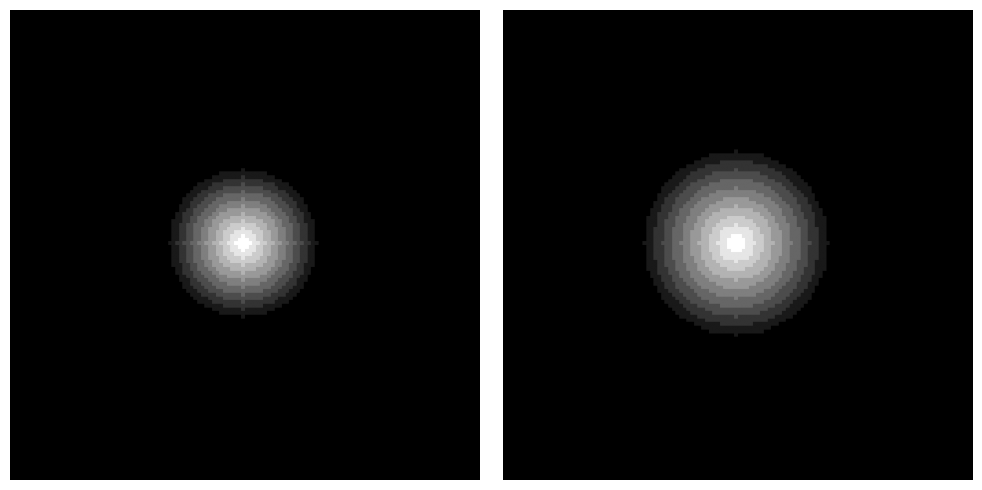

In [37]:
# Open images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import time

path_1 = "images x TP's/images synthétiques/1.png"
path_2 = "images x TP's/images synthétiques/2.png"

img1 = mpimg.imread(path_1)
img2 = mpimg.imread(path_2)

def rgb_to_grayscale(img):
    R = img[..., 0]
    G = img[..., 1]
    B = img[..., 2]

    img_gray = 0.2989 * R + 0.5870 * G + 0.1140 * B

    return img_gray

img1 = rgb_to_grayscale(img1)
img2 = rgb_to_grayscale(img2)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img1, cmap='gray')
axes[0].axis('off')
axes[1].imshow(img2, cmap='gray')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [38]:
# Function definition to visualise vectors
def visualize_motion_vectors(frame, motion_vectors, step=7, scale = 2):
    plt.figure(figsize=(12, 6))
    plt.imshow(frame, cmap='gray', alpha=0.7)

    h, w = frame.shape
    x_coords, y_coords = np.mgrid[0:h:step, 0:w:step]
    # y_coords, x_coords = np.mgrid[0:h:step, 0:w:step]/
    u = motion_vectors[::step, ::step, 0]
    v = motion_vectors[::step, ::step, 1]

    plt.quiver(
        x_coords, y_coords,
        u * scale, v * scale,
        angles='xy', scale_units='xy', scale=1,
        color='red', width=0.003
    )

    plt.axis('off')
    plt.tight_layout()
    
    plt.show()

## A - Backward BMA

Au TP1, vous avez réalisé de l’estimation de mouvement de type forward
par blocs entre F1 et F2. Procédez maintenant à de l’estimation backward par
blocs entre F1 et F2.  
Note : c’est désormais F2 que l’on décompose en blocs et non pas F1.

Pour cela, il suffit simplement de récuperer notre code de BMA du TP1 et d'inverser les images pour que l'image F2 soit découpée en blocs plutot que l'image F1. On constate toujours les séparation discontinue entre chaque bloc, en fonction de la taille de bloc choisie.

In [39]:
from scipy.ndimage import gaussian_filter

# Following formula
def bilinear_interpolate(img: np.ndarray, rows: np.ndarray, cols: np.ndarray):
    h, w = img.shape

    r0 = np.floor(rows).astype(int)
    c0 = np.floor(cols).astype(int)
    r1 = np.clip(r0 + 1, 0, h-1)
    c1 = np.clip(c0 + 1, 0, w-1)
    r0 = np.clip(r0, 0, h-1)
    c0 = np.clip(c0, 0, w-1)
    Ia = img[r0, c0]
    Ib = img[r0, c1]
    Ic = img[r1, c0]
    Id = img[r1, c1]
    wa = (r1 - rows) * (c1 - cols)
    wb = (r1 - rows) * (cols - c0)
    wc = (rows - r0) * (c1 - cols)
    wd = (rows - r0) * (cols - c0)
    return wa*Ia + wb*Ib + wc*Ic + wd*Id

def regularize_gaussian(mv: np.ndarray, sigma: float = 1.0):
    mv_dx = gaussian_filter(mv[...,0], sigma=sigma)
    mv_dy = gaussian_filter(mv[...,1], sigma=sigma)
    return np.stack((mv_dx, mv_dy), axis=-1)

def node_bma(
    img1: np.ndarray,
    img2: np.ndarray,
    block_size: int = 16,
    num_iters: int = 20,
    mu: float = 10,
    h_step: float = 10
):

    h, w = img1.shape
    mv = np.zeros((h, w, 2), dtype=np.float32)

    for x0 in range(0, h, block_size):
        if x0 + block_size > h:
            continue
        for y0 in range(0, w, block_size):
            if y0 + block_size > w:
                continue

            x_min, x_max = x0, x0 + block_size - 1
            y_min, y_max = y0, y0 + block_size - 1
            cste = (x_max - x_min) * (y_max - y_min)

            xs = np.arange(x_min, x_min + block_size)
            ys = np.arange(y_min, y_min + block_size)
            X, Y = np.meshgrid(xs, ys, indexing='ij')  # (block_size, block_size)

            phi1 = ((x_max - X) * (y_max - Y)) / cste
            phi2 = ((X - x_min) * (y_max - Y)) / cste
            phi3 = ((x_max - X) * (Y - y_min)) / cste
            phi4 = ((X - x_min) * (Y - y_min)) / cste
            phis = [phi1, phi2, phi3, phi4]

            d = np.zeros(8, dtype=np.float32)

            I1_block = img1[x0:x0+block_size, y0:y0+block_size]

            # Gradient Descent
            for _ in range(num_iters):

                dx = sum(d[2*k]   * phis[k] for k in range(4))
                dy = sum(d[2*k+1] * phis[k] for k in range(4))
                I2_warp = bilinear_interpolate(img2, X + dx, Y + dy)
                E = np.sum((I2_warp - I1_block)**2)

                grad = np.zeros_like(d)
                for l in range(8):
                    d_plus = d.copy()
                    d_plus[l] += h_step
                    dx_p = sum(d_plus[2*k]   * phis[k] for k in range(4))
                    dy_p = sum(d_plus[2*k+1] * phis[k] for k in range(4))
                    I2_p = bilinear_interpolate(img2, X + dx_p, Y + dy_p)
                    E_p = np.sum((I2_p - I1_block)**2)
                    grad[l] = (E_p - E) / h_step

                d -= mu * grad

            mv[x0:x0+block_size, y0:y0+block_size, 0] = dx
            mv[x0:x0+block_size, y0:y0+block_size, 1] = dy

    return regularize_gaussian(mv, 10)

Exec time : 8.464779138565063


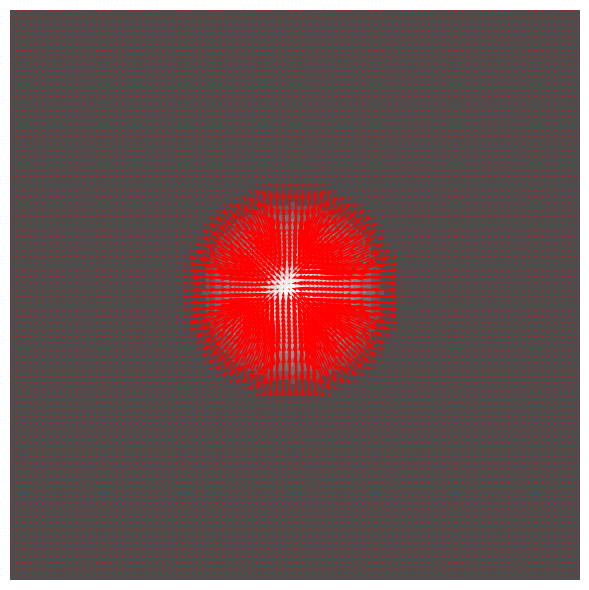

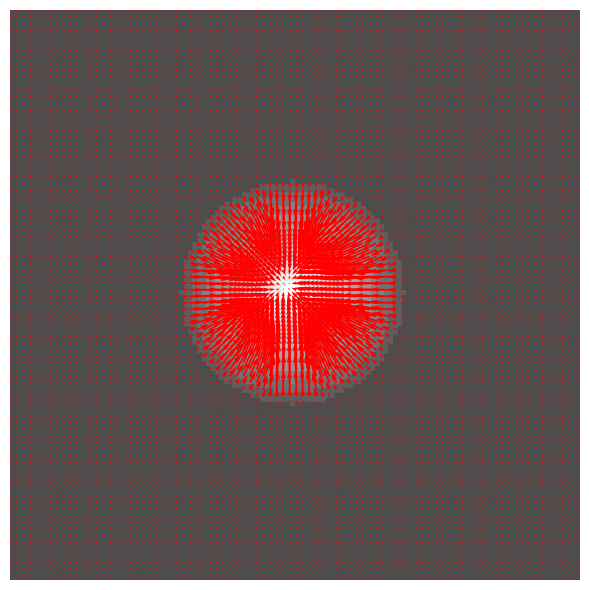

In [40]:
k = 10 # Size of neighbours pixels explored
block_size = 16 # 16x16

start = time.time()
mv = node_bma(img2, img1, block_size)
print(f'Exec time : {time.time() - start}')

visualize_motion_vectors(img1, mv)
visualize_motion_vectors(img2, mv)

## B - Justification Backward

Sachant que l’on va vouloir reconstruire la frame F2 à partir de F1,
pourquoi a-t-on donc fait de la ME backward et pas de la ME forward ? Que
se serait-il passé sinon ? (pensez à quels artéfacts visuels on aurait obtenu). 


L'objectif est de reconstruire chaque pixel de l'image F2. Alors que la ME forward cherche la destination des pixels de F1 vers F2, la ME backward recherche l'origine de chaque pixel de F2 dans F1.  

Dans la ME forward, certains pixels dans F2 n'auront aucune origine identifiée (trous) tandis que d'autres en auront plusieurs (collisons). Cependant dans la ME backward chaque pixel dans F2 connait son origine exacte dans F1.  


En résumé, la ME forward introduit des trous et collisions que la ME backward n'introduit pas.

## C - Reconstruction

Exec time : 3.07191801071167
MSE de reconstruction : 0.0005


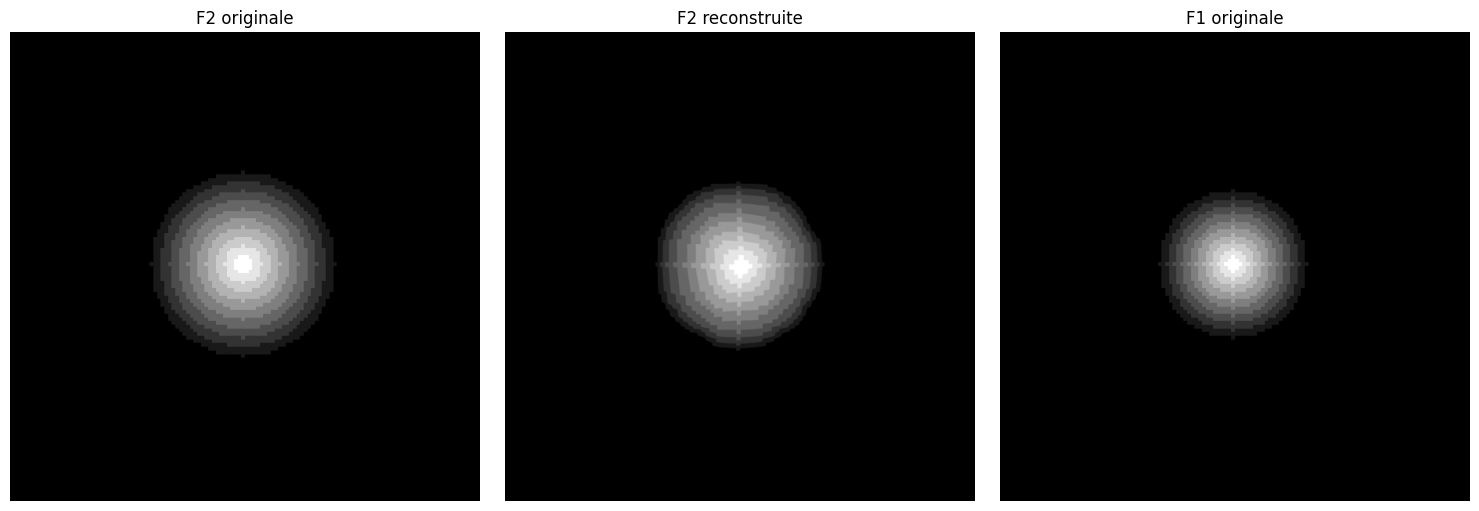

In [41]:
h, w = img1.shape
X, Y = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')

block_size = 32
start = time.time()
mv = node_bma(img2, img1, block_size, mu=5)
print(f'Exec time : {time.time() - start}')

F2_pred = bilinear_interpolate(img1, X + mv[...,0], Y + mv[...,1])
mse = np.mean((F2_pred - img2)**2)
print(f"MSE de reconstruction : {mse:.4f}")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img2, cmap='gray')
axes[0].set_title("F2 originale")
axes[0].axis('off')

axes[1].imshow(F2_pred, cmap='gray')
axes[1].set_title("F2 reconstruite")
axes[1].axis('off')

axes[2].imshow(img1, cmap='gray')
axes[2].set_title("F1 originale")
axes[2].axis('off')

plt.tight_layout()
plt.show()

On constate donc une bonne reconstruction avec une légère difficulté en périphérie. De plus, la MSE est très basse (0.005) confirmant ce que l'on observe.  

Les deux plus grosses difficultés de cette méthode sont la reconstruction en périphérie du cercle et la propagation de certains artéfacts de l'image F1 comme on peut l'observer sur les diagonales ou encore sur le centre qui ne forme pas un cercle comme dans l'image F2. 

## D - Reconstruction sans image F2

Supposant que l’on n’aura plus accès à F2, quelles sont les 3 données
”classiques” (en plus du paramàtre de taille de bloc) dont on a besoin pour la
reconstruire de façon parfaite en compensation de mouvement ?  

Pour être capable de reconstruire de façon parfaite sans accès à F2, il nous faut :
- La frame de référence F1
- Le champ de vecteurs de mouvement.
- Les résidus de prédiction (DFD)

Ainsi pour reconstruire parfaitement l'image F2 : F2_pred(x) = F1( x − MV(x) ) + résidu(x)

## E - Reconstruction sans image F2 (application)

Reconstruisez F2 à partir de ces 3 données. Quelle est désormais la MSE
de reconstruction ?

MSE de reconstruction parfaite (avec résidu) : 0.00000000


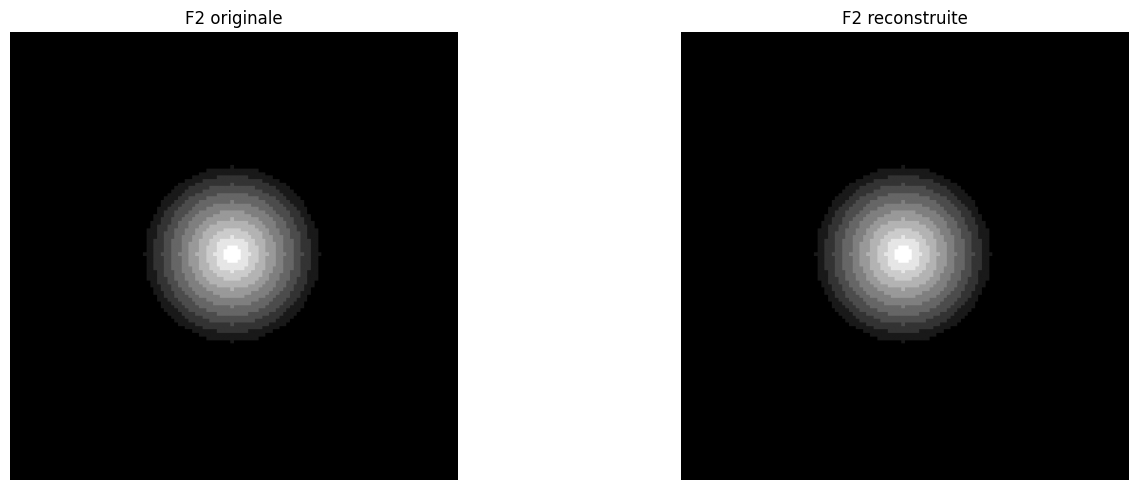

In [42]:
dfd = img2 - F2_pred
F2_reconstruct = F2_pred + dfd

mse_reconstruct = np.mean((F2_reconstruct - img2)**2)
print(f"MSE de reconstruction parfaite (avec résidu) : {mse_reconstruct:.8f}")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(img2, cmap='gray')
axes[0].set_title("F2 originale")
axes[0].axis('off')

axes[1].imshow(F2_reconstruct, cmap='gray')
axes[1].set_title("F2 reconstruite")
axes[1].axis('off')

plt.tight_layout()
plt.show()

## F - Codage des données

Expliquez quelles données on peut coder avec perte pour garder une
qualité de reconstruction de F1 et F2 ”correcte”. Justifiez vos explications par
des images de rendus.

On rappelle que la reconstruction de F2 à partir de F1 repose sur trois composantes :
- La frame de référence F1
- Le champ de vecteurs de mouvement.
- Les résidus de prédiction (DFD)
Donc : F2 = compensation(F1, MV) + DFD  

Voici ce qu'on peut coder avec perte :
- Le champ de vecteurs de mouvement, que l'on peut quantifier ou coder avec une precision réduite.
- Les résidus de prédiction (DFD)  

Par contre nous ne pouvons pas perdre l'image F1 qui doit être transmise sans perte ou reconstruite correctement en amont.

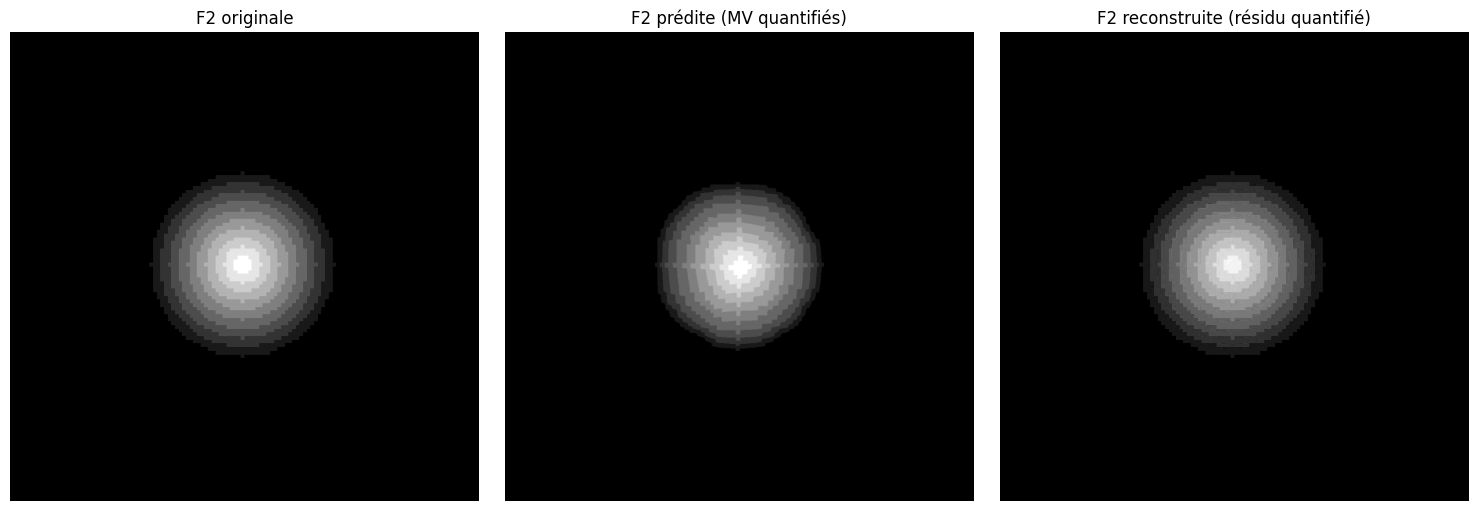

MSE avec MV quantifiés : 0.0005
MSE finale avec DFD quantifié : 0.0000


In [ ]:
# MV quantization
mv_quant = np.round(mv * 2) / 2 
F2_pred_q = bilinear_interpolate(img1, X + mv_quant[...,0], Y + mv_quant[...,1])
mse_q = np.mean((F2_pred_q - img2)**2)

# DFD quantization
dfd_q = np.round(dfd * 10) / 10
F2_reconstruct_q = F2_pred + dfd_q
mse_reconstruct_q = np.mean((F2_reconstruct_q - img2)**2)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img2, cmap='gray')
axes[0].set_title("F2 originale")
axes[0].axis('off')
axes[1].imshow(F2_pred_q, cmap='gray')
axes[1].set_title("F2 prédite (MV quantifiés)")
axes[1].axis('off')
axes[2].imshow(F2_reconstruct_q, cmap='gray')
axes[2].set_title("F2 reconstruite (résidu quantifié)")
axes[2].axis('off')
plt.tight_layout()
plt.show()

print(f"MSE avec MV quantifiés : {mse_q:.4f}")
print(f"MSE finale avec DFD quantifié : {mse_reconstruct_q:.4f}")


Ces approximations permettent une réduction de débit significative, avec peu de perte visuelle, en particulier si on ajuste bien la quantification. Dans notre cas, il n'y a ni dégradation visuelle, ni baisse de la MSE.

**Conclusion** :  

- L’image F2 prédite montre une approximation correcte, mais avec des artefacts visibles : effet en croix, difficulté en périphérie.
- L’image F2 reconstruite offre une bonne reconstruction de l’image originale, car le résidu permet de corriger les erreurs de prédiction.
- En quantifiant les vecteurs de mouvement et le résidu on obtiens une reduction de débit. En particulier, en arrondissant les vecteurs de mouvement à la précision 0.5 pixel, on réduit le nombre de valeurs distinctes à coder pour les MV.

Le compromis entre qualité et compression est bien équilibré ici, d'autant plus que nous ne subissons pas de perte sur le MSE.